In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipypb import irange

from DataProcessor import DataProcessor
from sals_eta import get_scores_generator, fit_restricted
from evaluation import evaluate, evaluation_callback

# Load and preprocess the data:

In [2]:
data_file_name = "lsapp.csv"

if data_file_name == "lsapp.csv":
    process_data = DataProcessor(
        "lsapp.csv",
        column_names='userid,appid,timestamp',
        session_break_delta='15min',
    )

    process_data.prepare_data(
        usecols=['userid', 'appid', 'timestamp'],
        test_interval='14d',
        valid_interval='7d',
        min_sess_length=2,
        window="3s",
    )

    # Define global weighting matrix
    Cui = process_data.get_freqs(process_data.train, c0=1, gamma=1)

    # Define user-contex matrix:
    Sus_dict = process_data.get_users_sui(process_data.train, level='sessid')
    Sus_dict = pd.Series(Sus_dict)
    print(data_file_name)
else:
    assert False, "Stop here"

lsapp.csv


# Train the model:

In [3]:
uid2Sui = process_data.get_users_sui(process_data.train, level='userid')

In [4]:
def get_scores_generator(local_factors, global_factors):
    P, eta = local_factors
    Q, Qb = global_factors
    par = 1
    if eta is not None:
        def generate_scores(uid, sid, sess_items, item_pool):
            k_back = min(len(sess_items), par) 
            scores = Q[item_pool] @ (P[uid] + eta[uid] * Qb[sess_items[:]].sum(axis=0))
            return scores
        return generate_scores

    def generate_scores(uid, sid, sess_items, item_pool):
        k_back = min(len(sess_items), par) 
        scores = Q[item_pool] @ (P[uid] + Qb[sess_items[-k_back:]].sum(axis=0))
        return scores
    return generate_scores

In [5]:
smf_callback = evaluation_callback(
    get_scores_generator,
    process_data.valid_sessions,
    process_data.seen_interactions, 
    factor_names=["ULF", "CLF", "IGF", "CGF"],
)


n_factors = 256
regularization = 0.001
gain = 1e-4
seed = 13
n_iter = 15

train = fit_restricted
local_factors, global_factors = train(
    Cui,
    uid2Sui,
    n_factors,
    regularization,
    gain,
    n_iter=n_iter,
    seed=seed,
    evaluation_callback=smf_callback,
    iterator=irange,
    use_eta=True,
)

 [████████████████████████████████████████████████████████████] 15/15 [00:15<00:01, 0.98s/it]

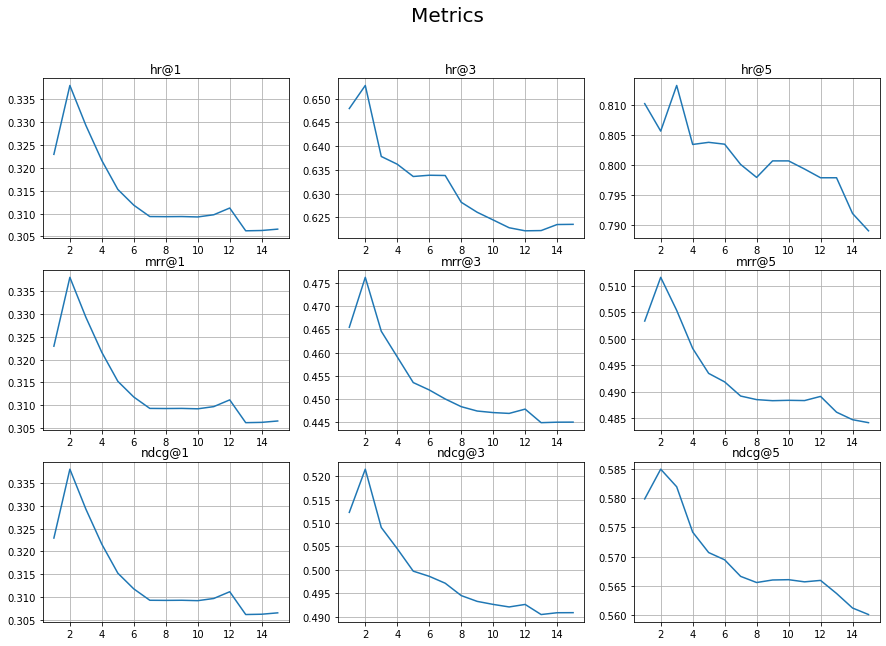

In [6]:
plt.rcParams["figure.figsize"] = (15, 10)

epochs = np.arange(1, n_iter + 1)
stat_metrics = list(smf_callback.stat.keys())[:-1]
topk = smf_callback.stat[stat_metrics[0]].keys()

fig, axs = plt.subplots(3, 3)
fig.suptitle("Metrics", fontsize=20)
for i, metric in enumerate(stat_metrics):
    for j, k in enumerate(topk):
        axs[i, j].plot(epochs, smf_callback.stat[metric][k])
        axs[i, j].set_title(f"{metric}@{k}")
        axs[i, j].grid(True)

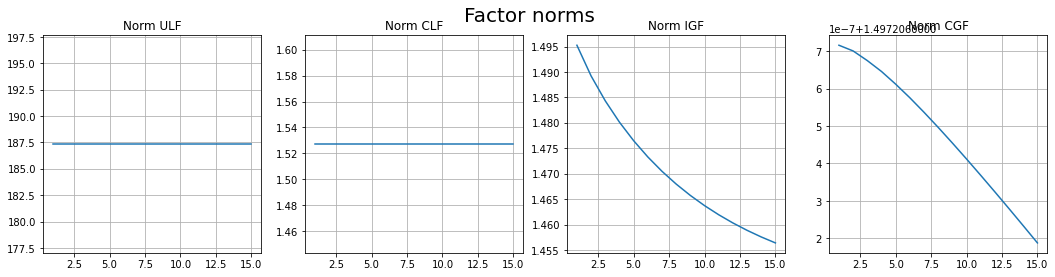

In [7]:
plt.rcParams["figure.figsize"] = (18, 4)
model_metrics = smf_callback.stat["norms"].keys()

fig, axs = plt.subplots(1, 4)
fig.suptitle("Factor norms", fontsize=20)
for j, name in enumerate(model_metrics):
    axs[j].plot(epochs, smf_callback.stat["norms"][name])
    axs[j].set_title(f"Norm {name}")
    axs[j].grid(True)

np.linalg.norm(local_factors[0]), np.linalg.norm(global_factors[0]), np.linalg.norm(global_factors[1])

In [8]:
max(smf_callback.stat["hr"][5])

0.8133432080530271

# Evaluation:

## Long-term + Short-term:

In [9]:
up_generate_scores = get_scores_generator(local_factors, global_factors)

metrics_df, user_stats = evaluate(
    up_generate_scores,
    process_data.test_sessions,
    process_data.seen_interactions,
)

test_results = (
    metrics_df
    .reset_index()
    .groupby(["topk"])
    .mean()[["hr", "mrr", "ndcg"]]
)

test_results

metrics,hr,mrr,ndcg
topk,,,
1,0.400761,0.400761,0.400761
3,0.645818,0.504612,0.540702
5,0.763005,0.532226,0.589697


## Only Long-Term:

In [10]:
def get_scores_generator_1(local_factors, global_factors):
    P, eta = local_factors
    Q, Qb = global_factors
    def generate_scores(uid, sid, sess_items, item_pool):
        scores = P[uid] @ Q[item_pool].T
        return scores 
    return generate_scores

up_generate_scores = get_scores_generator_1(local_factors, global_factors)

metrics_df, user_stats = evaluate(
    up_generate_scores,
    process_data.test_sessions,
    process_data.seen_interactions,
)

test_results = (
    metrics_df
    .reset_index()
    .groupby(["topk"])
    .mean()[["hr", "mrr", "ndcg"]]
)

test_results

metrics,hr,mrr,ndcg
topk,,,
1,0.402657,0.402657,0.402657
3,0.646238,0.507336,0.542897
5,0.762958,0.534898,0.591748


## Only Short-Term:

In [11]:
def get_scores_generator_2(local_factors, global_factors):
    P, eta = local_factors
    Q, Qb = global_factors
    def generate_scores(uid, sid, sess_items, item_pool):
        scores = Qb[sess_items[-1]] @ Q[item_pool].T
        return scores 
    return generate_scores

up_generate_scores = get_scores_generator_2(local_factors, global_factors)

metrics_df, user_stats = evaluate(
    up_generate_scores,
    process_data.test_sessions,
    process_data.seen_interactions,
)

test_results = (
    metrics_df
    .reset_index()
    .groupby(["topk"])
    .mean()[["hr", "mrr", "ndcg"]]
)

test_results

metrics,hr,mrr,ndcg
topk,,,
1,0.154825,0.154825,0.154825
3,0.328013,0.233809,0.258116
5,0.422940,0.255696,0.297382


## Like in SVD:

In [12]:
def get_scores_generator_4(local_factors, global_factors):
    P, eta = local_factors
    Q, Qb = global_factors
    def generate_scores(uid, sid, sess_items, item_pool):
        scores = Q[item_pool] @ Q[sess_items].sum(axis=0)
        return scores 
    return generate_scores

up_generate_scores = get_scores_generator_4(local_factors, global_factors)

metrics_df, user_stats = evaluate(
    up_generate_scores,
    process_data.test_sessions,
    process_data.seen_interactions,
)

test_results = (
    metrics_df
    .reset_index()
    .groupby(["topk"])
    .mean()[["hr", "mrr", "ndcg"]]
)

test_results

metrics,hr,mrr,ndcg
topk,,,
1,0.546542,0.546542,0.546542
3,0.827861,0.673823,0.713525
5,0.890445,0.688328,0.739478


## Only Q and last one from session:

In [13]:
def get_scores_generator_3(local_factors, global_factors):
    P, eta = local_factors
    Q, Qb = global_factors
    def generate_scores(uid, sid, sess_items, item_pool):
        scores = Q[item_pool] @ Q[sess_items[-1]]
        return scores 
    return generate_scores

up_generate_scores = get_scores_generator_3(local_factors, global_factors)

metrics_df, user_stats = evaluate(
    up_generate_scores,
    process_data.test_sessions,
    process_data.seen_interactions,
)

test_results = (
    metrics_df
    .reset_index()
    .groupby(["topk"])
    .mean()[["hr", "mrr", "ndcg"]]
)

test_results

metrics,hr,mrr,ndcg
topk,,,
1,0.616732,0.616732,0.616732
3,0.719164,0.661294,0.676132
5,0.794454,0.678716,0.707330
